DATASET CLEANING, PREPROCESSING, AND FEATURE ENGINEERING

In [1]:
import pandas as pd
import Configurations as CF

In [2]:
df = pd.read_csv("Data/Formations_info.csv")

In [3]:
df.columns

Index(['Formation', 'Mode', 'Formation Base', 'Description', 'Available In',
       'Counter Formations', 'GK', 'LCB', 'CB', 'RCB', 'RM', 'RCM', 'CDM',
       'LCM', 'LM', 'LS', 'RS', 'RB', 'LB', 'RWB', 'LWB', 'CM', 'CAM', 'RW',
       'LW', 'ST', 'CF', 'LF', 'RF', 'RAM', 'LAM', 'LDM', 'RDM'],
      dtype='str')

In [4]:
for col in df.columns:
    if col in CF.ROLE_LIST:
        print(f"{col} - {df[col].unique()}")

In [5]:
df[['LCB', 'CB', 'RCB']].head(10)

,LCB,CB,RCB
0,1,1,1
1,0,3,0
2,0,3,0
3,1,1,1
4,1,1,1
5,1,1,1
6,0,3,0
7,0,2,0
8,0,2,0
9,1,0,1


In [6]:
cols = ['GK', 'LCB', 'CB', 'RCB', 'RM', 'RCM', 'CDM',
       'LCM', 'LM', 'LS', 'RS', 'RB', 'LB', 'RWB', 'LWB', 'CM', 'CAM', 'RW',
       'LW', 'ST', 'CF', 'LF', 'RF', 'RAM', 'LAM', 'LDM', 'RDM']

df["Total Players"] = df[cols].sum(axis=1)

In [7]:
df = df[df["Total Players"] == 11]
df.shape

(45, 34)

In [8]:
df["Total Players"].unique()

array([11])

In [9]:
def normalize_three_role(df, main, left, center, right):

    # Only normalize rows where side roles are empty
    mask = (
        (df[main] > 1) &
        (df[left] == 0) &
        (df[right] == 0)
    )

    # Case 1: exactly 2 → left + right
    mask_2 = mask & (df[main] == 2)
    df.loc[mask_2, left] = 1
    df.loc[mask_2, right] = 1
    df.loc[mask_2, main] = 0   # remove aggregated

    # Case 2: 3 or more
    mask_3 = mask & (df[main] >= 3)

    df.loc[mask_3, left] = 1
    df.loc[mask_3, right] = 1

    # Only set center if it is NOT the same as main
    if center != main:
        df.loc[mask_3, center] = 1
        df.loc[mask_3, main] = 0
    else:
        # center == main (like CB case)
        df.loc[mask_3, main] = 1

    return df


In [10]:
# Apply normalization
df = normalize_three_role(df, "CB", "LCB", "CB", "RCB")
df = normalize_three_role(df, "CM", "LCM", "CM", "RCM")
df = normalize_three_role(df, "CAM", "LAM", "CAM", "RAM")
df = normalize_three_role(df, "CDM", "LDM", "CDM", "RDM")
df = normalize_three_role(df, "ST", "LS", "ST", "RS")


In [11]:
df[["LCB", "CB", "RCB"]].head(10)

,LCB,CB,RCB
0,1,1,1
1,1,1,1
2,1,1,1
3,1,1,1
4,1,1,1
5,1,1,1
6,1,1,1
7,1,0,1
8,1,0,1
9,1,0,1


In [12]:
import numpy as np

def split_formation_name(name):
    parts = name.split(" ", 1)  # split only on first space
    
    structure = parts[0]
    
    if len(parts) > 1:
        shape = parts[1]
    else:
        shape = np.nan
        
    return pd.Series([structure, shape])


df[["Structure", "Shape"]] = df["Formation"].apply(split_formation_name)
df[["Formation", "Structure", "Shape", "Mode"]].head(5)

,Formation,Structure,Shape,Mode
0,3-1-4-2,3-1-4-2,NaN,Attacking / Midfield (Moderate)
1,3-4-1-2,3-4-1-2,NaN,Attacking (Moderate)
2,3-4-2-1,3-4-2-1,NaN,Attacking
3,3-4-3 Diamond,3-4-3,Diamond,Attacking
4,3-4-3 Flat,3-4-3,Flat,Attacking


In [13]:
# First clean mode text (remove bracket text like "(Moderate)")
df["Mode"] = df["Mode"].str.replace(r"\(.*?\)", "", regex=True)

# Split by "/"
df["Mode"] = df["Mode"].str.split("/")

# Explode into multiple rows
df = df.explode("Mode")

# Clean spaces
df["Mode"] = df["Mode"].str.strip()

df[["Formation", "Structure", "Shape", "Mode"]].head(5)

,Formation,Structure,Shape,Mode
0,3-1-4-2,3-1-4-2,NaN,Attacking
0,3-1-4-2,3-1-4-2,NaN,Midfield
1,3-4-1-2,3-4-1-2,NaN,Attacking
2,3-4-2-1,3-4-2-1,NaN,Attacking
3,3-4-3 Diamond,3-4-3,Diamond,Attacking


In [14]:
df.columns

Index(['Formation', 'Mode', 'Formation Base', 'Description', 'Available In',
       'Counter Formations', 'GK', 'LCB', 'CB', 'RCB', 'RM', 'RCM', 'CDM',
       'LCM', 'LM', 'LS', 'RS', 'RB', 'LB', 'RWB', 'LWB', 'CM', 'CAM', 'RW',
       'LW', 'ST', 'CF', 'LF', 'RF', 'RAM', 'LAM', 'LDM', 'RDM',
       'Total Players', 'Structure', 'Shape'],
      dtype='str')

In [15]:
cols = [ 'GK', 'LCB', 'CB', 'RCB', 'RM', 'RCM', 'CDM',
       'LCM', 'LM', 'LS', 'RS', 'RB', 'LB', 'RWB', 'LWB', 'CM', 'CAM', 'RW',
       'LW', 'ST', 'CF', 'LF', 'RF', 'RAM', 'LAM', 'LDM', 'RDM']

df["Total Players"] = df[cols].sum(axis=1)
df["Total Players"].unique()

array([11])

In [16]:
len(cols)

27

In [17]:
len(CF.ROLE_LIST)

27

In [18]:
final_cols = ( 
    ["Formation", "Structure", "Shape", 'Mode', 'Formation Base'] +
    CF.ROLE_VALUE_LIST +
    ["Total Players", 'Counter Formations', "Description"]
)
len(final_cols)

35

In [19]:
df = df[final_cols]
df.head()

,Formation,Structure,Shape,Mode,Formation Base,GK,LCB,CB,RCB,LB,...,RW,CF,LF,RF,ST,LS,RS,Total Players,Counter Formations,Description
0,3-1-4-2,3-1-4-2,NaN,Attacking,3-5-2,1,1,1,1,0,...,0,0,0,0,0,1,1,11,4-5-1 / 4-1-3-2,Suitable for the games you’re trying to win an...
0,3-1-4-2,3-1-4-2,NaN,Midfield,3-5-2,1,1,1,1,0,...,0,0,0,0,0,1,1,11,4-5-1 / 4-1-3-2,Suitable for the games you’re trying to win an...
1,3-4-1-2,3-4-1-2,NaN,Attacking,3-5-2,1,1,1,1,0,...,0,0,0,0,0,1,1,11,4-5-1,Suitable for the games you are trying to win b...
2,3-4-2-1,3-4-2-1,NaN,Attacking,3-4-3,1,1,1,1,0,...,0,0,1,1,1,0,0,11,4-5-1 / 4-2-3-1,A variation of 3-4-1-2 formation but more atta...
3,3-4-3 Diamond,3-4-3,Diamond,Attacking,3-4-3,1,1,1,1,0,...,1,0,0,0,1,0,0,11,4-3-1-2 / 4-2-3-1 / 5-3-2,Suitable for the games where you want to conce...


In [20]:
df["Defenders"] = df[["LCB","CB","RCB","LB","RB","LWB","RWB"]].sum(axis=1)
df["Midfielders"] = df[["CDM","LDM","RDM","CM","LCM","RCM","CAM","LAM","RAM","LM","RM"]].sum(axis=1)
df["Forwards"] = df[["CB", "CDM", "CM", "CAM","CF"]].sum(axis=1)

In [21]:
df["Left_Weight"] = df[["LB","LCB","LCM","LM","LW","LAM","LDM"]].sum(axis=1)
df["Right_Weight"] = df[["RB","RCB","RCM","RM","RW","RAM","RDM"]].sum(axis=1)
df["Middle_Weight"] = df[["RB","RCB","RCM","RM","RW","RAM","RDM"]].sum(axis=1)
df["Symmetry"] = abs(df["Left_Weight"] - df["Right_Weight"])

In [22]:
df.sample(5)

,Formation,Structure,Shape,Mode,Formation Base,GK,LCB,CB,RCB,LB,...,Total Players,Counter Formations,Description,Defenders,Midfielders,Forwards,Left_Weight,Right_Weight,Middle_Weight,Symmetry
23,4-3-3 (4),4-3-3,(4),Attacking,4-3-3,1,1,0,1,1,...,11,3-4-2-1 / 3-5-2,This formation is slightly more attacking than...,4,3,1,4,4,4,0
40,5-2-2-1,5-2-2-1,NaN,Attacking,5-2-3,1,1,1,1,0,...,11,4-3-3,This formation includes 5 defenders including ...,5,2,1,3,3,3,0
44,5-4-1 Diamond,5-4-1,Diamond,Defending,NaN,1,1,1,1,0,...,11,3-5-2,A slight attacking edition of the 5-4-1 format...,5,4,3,2,2,2,0
31,4-4-2,4-4-2,NaN,Midfield,NaN,1,1,0,1,1,...,11,3-4-2-1 / 3-5-2 / 4-4-1-1,The 4-4-2 formation usually staggers the midfi...,4,4,0,4,4,4,0
22,4-3-3 (3),4-3-3,(3),Defending,4-3-3,1,1,0,1,1,...,11,3-4-2-1 / 3-5-2,4-3-3 (3) formation is even more defensive tha...,4,3,1,4,4,4,0


In [23]:
df['Formation'] = df['Formation'].astype(str) + " " + df['Mode'].astype(str)
df.sample(5)

,Formation,Structure,Shape,Mode,Formation Base,GK,LCB,CB,RCB,LB,...,Total Players,Counter Formations,Description,Defenders,Midfielders,Forwards,Left_Weight,Right_Weight,Middle_Weight,Symmetry
45,5-4-1 Flat Defending,5-4-1,Flat,Defending,NaN,1,1,1,1,0,...,11,3-5-2,The 5-4-1 formation is a particularly defensiv...,5,4,1,3,3,3,0
18,4-3-1-2 Attacking,4-3-1-2,NaN,Attacking,4-4-2,1,1,0,1,1,...,11,3-4-3 / 5-3-2,Suitable for the games where you want to attac...,4,4,2,3,3,3,0
33,4-4-2 Flat Midfield,4-4-2,Flat,Midfield,4-4-2,1,1,0,1,1,...,11,3-4-2-1 / 3-5-2 / 4-4-1-1,The 4-4-2 formation usually staggers the midfi...,4,4,0,4,4,4,0
37,4-5-1 Attack Attacking,4-5-1,Attack,Attacking,4-5-1,1,1,0,1,1,...,11,5-3-2,Suitable for the games that you need to have s...,4,5,1,4,4,4,0
40,5-2-2-1 Defending,5-2-2-1,NaN,Defending,5-2-3,1,1,1,1,0,...,11,4-3-3,This formation includes 5 defenders including ...,5,2,1,3,3,3,0


In [24]:
df.to_csv("Data/Formations_info_transformed.csv", index=False)

In [25]:
df = df.drop(['Description', 'Counter Formations'], axis=1)

In [26]:
df["Structure"].value_counts()

Structure
4-3-3        18
4-1-2-1-2     8
4-4-2         8
4-5-1         7
5-4-1         6
4-2-3-1       4
3-1-4-2       2
3-4-3         2
4-1-4-1       2
4-2-2-2       2
4-3-1-2       2
4-3-2-1       2
4-4-1-1       2
5-2-1-2       2
5-2-2-1       2
5-2-3         2
5-3-2         2
3-4-1-2       1
3-4-2-1       1
3-5-1-1       1
3-5-2         1
4-1-3-2       1
4-2-4         1
Name: count, dtype: int64

In [27]:
df.sample(5)

,Formation,Structure,Shape,Mode,Formation Base,GK,LCB,CB,RCB,LB,...,LS,RS,Total Players,Defenders,Midfielders,Forwards,Left_Weight,Right_Weight,Middle_Weight,Symmetry
33,4-4-2 Flat Midfield,4-4-2,Flat,Midfield,4-4-2,1,1,0,1,1,...,1,1,11,4,4,0,4,4,4,0
42,5-3-2 Defending,5-3-2,NaN,Defending,NaN,1,1,1,1,0,...,1,1,11,5,3,2,2,2,2,0
17,4-2-4 Attacking,4-2-4,NaN,Attacking,NaN,1,1,0,1,1,...,1,1,11,4,2,0,4,4,4,0
13,4-2-2-2 Defensive,4-2-2-2,NaN,Defensive,4-4-2,1,1,0,1,1,...,1,1,11,4,4,0,4,4,4,0
12,4-1-4-1 Attacking,4-1-4-1,NaN,Attacking,4-5-1,1,1,0,1,1,...,0,0,11,4,5,1,4,4,4,0


KNN MODEL TRAINING

In [28]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
import joblib
import Configurations as CF

df = pd.read_csv("Data/Formations_info_transformed.csv")

# FIXED: Use the centralized Configurations list to guarantee matching feature order!
role_cols = CF.ROLE_VALUE_LIST

# Combine Structure and Shape for a clean target (e.g., "4-3-3 Flat")
df['Base_Target'] = df['Structure'].astype(str) + " " + df['Shape'].fillna("").astype(str)
df['Base_Target'] = df['Base_Target'].str.strip()

X = df[role_cols]
y = df['Base_Target']

knn_model = KNeighborsClassifier(n_neighbors=1, metric='hamming')
knn_model.fit(X, y)

# Save the model to disk
joblib.dump(knn_model, "Models/knn_formation_model.pkl")
print("KNN Model saved successfully as knn_formation_model.pkl!")

KNN Model saved successfully as knn_formation_model.pkl!


/Users/sandalisingh/Downloads/SheInnovates-main/venv311/lib/python3.11/site-packages/sklearn/neighbors/_base.py:501: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  check_classification_targets(y)


KNN MODEL TESTING

In [29]:
import numpy as np
# Assuming FormationDetector is saved in a file named formation_detector.py
from FormationDetector import FormationDetector 

# Initialize the detector
detector = FormationDetector(
    formation_info_df="Data/Formations_info_transformed.csv", 
    knn_model_path="Models/knn_formation_model.pkl"
)

# Simulate a standard 4-3-3 team layout on a 105x68 pitch
# Order does not matter; the Hungarian algorithm handles the mapping
team_coords = np.array([
    [5.0, 34.0],   # GK
    [20.0, 15.0],  # LB
    [15.0, 28.0],  # LCB
    [15.0, 40.0],  # RCB
    [20.0, 53.0],  # RB
    [40.0, 34.0],  # CDM (Deep lying)
    [55.0, 20.0],  # LCM
    [55.0, 48.0],  # RCM
    [85.0, 15.0],  # LW
    [85.0, 53.0],  # RW
    [90.0, 34.0]   # ST
])

# Predict
pattern, mode, best_formation = detector.detect_formation_from_player_positions(
    team_coords, 
    team_side="left"
)

print("--- Coordinate Prediction Results ---")
print(f"Detected Line Pattern: {pattern}")
print(f"Detected Tactical Mode: {mode}")
print(f"Predicted Formation: {best_formation}")

TypeError: FormationDetector.__init__() got an unexpected keyword argument 'formation_info_df'

In [ ]:
import pandas as pd
import joblib
import Configurations as CF

def predict_from_roles(active_roles, model_path="Models/knn_formation_model.pkl"):
    # Load the trained model
    knn_model = joblib.load(model_path)
    
    # FIXED: Use centralized config
    role_cols = CF.ROLE_VALUE_LIST
    
    # Initialize a dictionary with all 0s
    feature_vector = {role: 0 for role in role_cols}
    
    # Set the active roles to 1
    for role in active_roles:
        if role in feature_vector:
            feature_vector[role] = 1
        else:
            print(f"Warning: Role '{role}' not recognized.")
            
    # Convert to DataFrame
    df_features = pd.DataFrame([feature_vector], columns=role_cols)
    
    # Predict
    prediction = knn_model.predict(df_features)[0]
    return prediction

# Example Usage
my_team_roles = ['GK', 'LB', 'LCB', 'RCB', 'RB', 'LDM', 'RDM', 'LAM', 'CAM', 'RAM', 'ST']
predicted_formation = predict_from_roles(my_team_roles)

print("\n--- Role Prediction Results ---")
print(f"Input Roles: {my_team_roles}")
print(f"Predicted Formation: {predicted_formation}")


--- Role Prediction Results ---
Input Roles: ['GK', 'LB', 'LCB', 'RCB', 'RB', 'LDM', 'RDM', 'LAM', 'CAM', 'RAM', 'ST']
Predicted Formation: 4-2-3-1


KNN MODEL EVALUATION

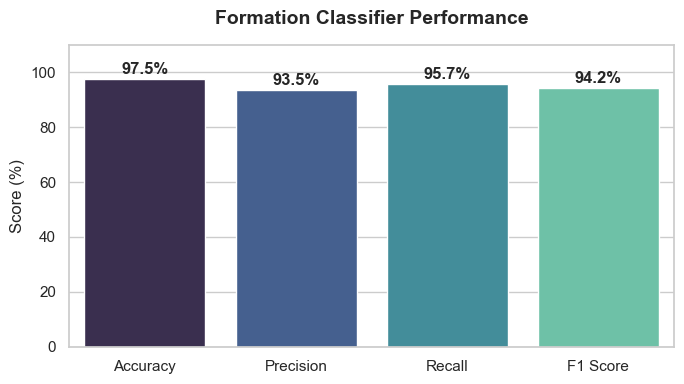

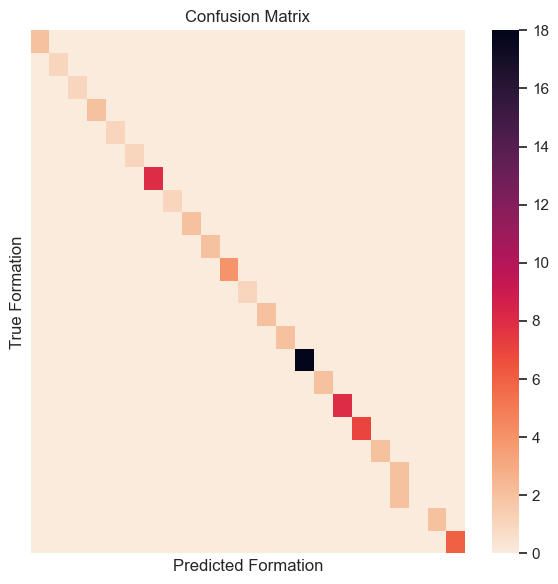

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
import Configurations as CF

# Ignore warnings for undefined metrics on single-sample classes
warnings.filterwarnings('ignore') 

# 1. Load Data & Model
df = pd.read_csv("Data/Formations_info_transformed.csv")
knn_model = joblib.load("Models/knn_formation_model.pkl")

# FIXED: Use centralized config
role_cols = CF.ROLE_VALUE_LIST

# 2. Extract Features 
# Passing the DataFrame directly (not .values) prevents the feature names warning
X_base = df[role_cols]

# 3. Predict & Format Targets
# The model predicts the full name (e.g., "4-3-3 Flat Attacking")
raw_preds = knn_model.predict(X_base)

# Extract just the core structure (e.g., "4-3-3") from the predictions
y_pred = [str(pred).split(" ")[0] for pred in raw_preds]

# Evaluate based on the core structure (4-3-3, 4-4-2, etc.) for standardized metrics
y_true = df['Structure'].astype(str)

# 4. Calculate Standard Macro Metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro')
rec = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# 5. Plotting the Chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
scores = [acc * 100, prec * 100, rec * 100, f1 * 100]

plt.figure(figsize=(7, 4))
sns.set_theme(style="whitegrid")
ax = sns.barplot(x=metrics, y=scores, palette="mako")

plt.title('Formation Classifier Performance', fontsize=14, fontweight='bold', pad=15)
plt.ylabel('Score (%)', fontsize=12)
plt.ylim(0, 110)

# Add score labels on top of bars
for i, score in enumerate(scores):
    ax.text(i, score + 2, f'{score:.1f}%', ha='center', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('Results/FormationClassifier/formation_classification_evaluation.png', dpi=300)
plt.show()

# ==========================================
# PLOT 2: Color-Coded Confusion Matrix
# ==========================================
# Get unique labels sorted alphabetically to ensure consistent matrix rendering
labels = sorted(list(set(y_true)))
cm = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(6, 6))
# annot=False removes the numbers, xticklabels=False/yticklabels=False keeps it clean
sns.heatmap(cm, cmap='rocket_r', xticklabels=False, yticklabels=False)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Formation')
plt.ylabel('True Formation')

plt.tight_layout()
plt.savefig('Results/FormationClassifier/formation_confusion_matrix.png', dpi=300)
plt.show()